## Begin

In [2]:
import pandas as pd

import shapely
import shapely.geometry as geometry
import plotly.express as px
import geopandas as gpd
import json

base_path = '../../FINAL data/'
my_data_path = '../../MY data/'

In [3]:
def str_to_multipoly(lst):
    # В некоторых строках вместо ',' стоят ';', тогда json не читается
    lst = lst.replace(';', ',')
    j = json.loads(lst)
    polygons = []
    for p in j:
        p = geometry.shape(p)
        polygons.append(p)

    polygons = geometry.MultiPolygon(polygons)
    return geometry.MultiPolygon(polygons)


def pd_to_gpd_w_geom(df):
    geoms = []
    for shape in df['geom']:
        geoms.append(shapely.from_wkb(shape))

    gdf = gpd.GeoDataFrame(df, geometry=geoms, crs="EPSG:4326")
    return gdf


def repalce_geometry_with_wkb(df):
    wkb = df.geometry.to_wkb(hex=True)
    df.drop(columns=['geometry'], inplace=True)
    df.rename(columns={'poly': 'geom'}, inplace=True)
    df['geom'] = wkb
    return df

In [42]:
import config.db_config as db_config

sf = db_config.session_factory()

## CSV

#### final_rosleshoz.csv


In [3]:
file_name = "final_rosleshoz.csv"
path = base_path + "/" + file_name
final_rosleshoz_df = pd.read_csv(path)

In [4]:
final_rosleshoz_df.head()

,new_fire_id,code,coords,locality_distance,lesn,date_start,area_registr,date_end,status,area_all,...,duration,month,status_category,area_union,count_ignitions,points,_typename,geometry,type,ids
0,7463,к-440 (112108),"53° 04' 26"" с.ш.\n102° 32' 53"" в.д.","н.п. Аларь, азимут 38°, удаление 0.5 км",Аларское,2020-04-08,90.0,2020-04-09,ликвидирован 14.04.2020,454,...,1,4,ликвидирован,4.54,1,NaN,Аларь,MULTIPOLYGON (((11416662.69007241 6997742.4409...,НП,[7463]
1,8614,к-1605 (213710),"53° 11' 49"" с.ш.\n102° 14' 53"" в.д.","н.п. Аляты, азимут 140°, удаление 2.4 км",Аларское,2020-06-29,80.0,2020-06-29,ликвидирован 4.07.2020,82,...,0,6,ликвидирован,0.82,1,NaN,Аляты,MULTIPOLYGON (((11382654.2483037 7019963.49327...,НП,[8614]
2,4406,к-600 (169231),"53° 27' 54"" с.ш.\n103° 21' 29"" в.д.","н.п. Ангарский, азимут 32°, удаление 0.6 км",Аларское,2019-04-29,17.0,2019-04-29,ликвидирован 4.05.2019,17,...,0,4,ликвидирован,0.17,1,NaN,Ангарский,MULTIPOLYGON (((11505972.26910861 7069683.9770...,НП,[4406]
3,7567,к-539 (116005),"53° 25' 16"" с.ш.\n102° 57' 43"" в.д.","н.п. Табарсук, азимут 117°, удаление 4.4 км",Аларское,2020-04-09,3.0,2020-04-09,ликвидирован 14.04.2020,28,...,0,4,ликвидирован,0.28,1,NaN,Дута,MULTIPOLYGON (((11461935.80177199 7061539.7212...,НП,[7567]
4,8808,к-1797 (218004),"53° 18' 22"" с.ш.\n103° 00' 29"" в.д.","н.п. Егоровская, азимут 252°, удаление 0.8 км",Аларское,2020-07-06,6.0,2020-07-06,ликвидирован 11.07.2020,7,...,0,7,ликвидирован,0.07,1,NaN,Егоровская,MULTIPOLYGON (((11466936.57961523 7039954.4280...,НП,[8808]


Разница между area и are_union есть


In [5]:
final_rosleshoz_df[final_rosleshoz_df['area_all_km']
                   != final_rosleshoz_df['area_union']][['area_union', 'area_all_km', 'area_all']]

,area_union,area_all_km,area_all
67,0.06,0.03,3
82,0.06,0.03,3
140,487.17,481.15,48115
160,47.20,46.30,4630
201,38.77,38.35,3835
...,...,...,...
9104,0.06,0.03,3
9105,0.06,0.03,3
9106,0.06,0.03,3
9177,0.17,0.14,14


Удалим колонки, дублирующие другие колонки по площади.


In [6]:
final_rosleshoz_df.drop(columns=[
                        "coords", "area_all_km", "area_forest_km", "count_ignitions"], inplace=True)

Ниже видно, что есть id пожара не обязательно равен id нового пожара.


In [7]:
len(final_rosleshoz_df[final_rosleshoz_df['id']
    != final_rosleshoz_df['new_fire_id']])

120

Поажры, у которых начало и конец в разных годах. Year — год начала. То же касается месяца.


In [8]:
final_rosleshoz_df[
    (pd.to_datetime(
        final_rosleshoz_df['date_start'], format='%Y-%m-%d').dt.month == 12)
    & (pd.to_datetime(
        final_rosleshoz_df['date_end'], format='%Y-%m-%d').dt.month == 1)][['date_start', 'date_end', 'year']]

,date_start,date_end,year
1296,2018-12-12,2019-01-05,2018
1391,2018-12-24,2019-01-16,2018
1450,2018-12-21,2019-01-09,2018
4539,2018-12-30,2019-01-06,2018
9274,2020-12-04,2021-01-11,2020
9275,2020-12-05,2021-01-11,2020


Удалим дублирование по времени


In [9]:
final_rosleshoz_df.drop(
    columns=["day_start", "day_end", "year", "month", "duration"], inplace=True)

Удалим лишние поля

In [10]:
final_rosleshoz_df.drop(columns=["points", 'ids', 'ps', 'ps2', 'buffer',
                        'new_fire_id', 'delta_area_all', 'delta_area_forest'], inplace=True)

In [11]:
final_rosleshoz_df.head()

,code,locality_distance,lesn,date_start,area_registr,date_end,status,area_all,area_forest,area_lesofond_all,...,lat,lon,forest,id,geometry_point,status_category,area_union,_typename,geometry,type
0,к-440 (112108),"н.п. Аларь, азимут 38°, удаление 0.5 км",Аларское,2020-04-08,90.0,2020-04-09,ликвидирован 14.04.2020,454,0,87,...,53.073889,102.548056,0.0,7463,POINT (11415597.32628477 6996677.077121332),ликвидирован,4.54,Аларь,MULTIPOLYGON (((11416662.69007241 6997742.4409...,НП
1,к-1605 (213710),"н.п. Аляты, азимут 140°, удаление 2.4 км",Аларское,2020-06-29,80.0,2020-06-29,ликвидирован 4.07.2020,82,0,3,...,53.196944,102.248056,0.0,8614,POINT (11382201.47904679 7019510.724017813),ликвидирован,0.82,Аляты,MULTIPOLYGON (((11382654.2483037 7019963.49327...,НП
2,к-600 (169231),"н.п. Ангарский, азимут 32°, удаление 0.6 км",Аларское,2019-04-29,17.0,2019-04-29,ликвидирован 4.05.2019,17,1,9,...,53.465000,103.358056,1.0,4406,POINT (11505766.11382733 7069477.82176244),ликвидирован,0.17,Ангарский,MULTIPOLYGON (((11505972.26910861 7069683.9770...,НП
3,к-539 (116005),"н.п. Табарсук, азимут 117°, удаление 4.4 км",Аларское,2020-04-09,3.0,2020-04-09,ликвидирован 14.04.2020,28,21,11,...,53.421111,102.961944,1.0,7567,POINT (11461671.22664088 7061275.146122432),ликвидирован,0.28,Дута,MULTIPOLYGON (((11461935.80177199 7061539.7212...,НП
4,к-1797 (218004),"н.п. Егоровская, азимут 252°, удаление 0.8 км",Аларское,2020-07-06,6.0,2020-07-06,ликвидирован 11.07.2020,7,2,7,...,53.306111,103.008056,1.0,8808,POINT (11466804.29204968 7039822.14047591),ликвидирован,0.07,Егоровская,MULTIPOLYGON (((11466936.57961523 7039954.4280...,НП


In [12]:
shapely.Point(final_rosleshoz_df.lat[0], final_rosleshoz_df.lon[0])

coords = shapely.points(final_rosleshoz_df['lon'],final_rosleshoz_df['lat'])

In [13]:
final_rosleshoz_df.columns


Index(['code', 'locality_distance', 'lesn', 'date_start', 'area_registr',
       'date_end', 'status', 'area_all', 'area_forest', 'area_lesofond_all',
       'area_lesofond_forest', 'lat', 'lon', 'forest', 'id', 'geometry_point',
       'status_category', 'area_union', '_typename', 'geometry', 'type'],
      dtype='object')

In [14]:
final_rosleshoz_df.drop(columns = ["lat", "lon", "status"], inplace=True)

In [15]:
final_rosleshoz_df.head()

,code,locality_distance,lesn,date_start,area_registr,date_end,area_all,area_forest,area_lesofond_all,area_lesofond_forest,forest,id,geometry_point,status_category,area_union,_typename,geometry,type
0,к-440 (112108),"н.п. Аларь, азимут 38°, удаление 0.5 км",Аларское,2020-04-08,90.0,2020-04-09,454,0,87,0,0.0,7463,POINT (11415597.32628477 6996677.077121332),ликвидирован,4.54,Аларь,MULTIPOLYGON (((11416662.69007241 6997742.4409...,НП
1,к-1605 (213710),"н.п. Аляты, азимут 140°, удаление 2.4 км",Аларское,2020-06-29,80.0,2020-06-29,82,0,3,0,0.0,8614,POINT (11382201.47904679 7019510.724017813),ликвидирован,0.82,Аляты,MULTIPOLYGON (((11382654.2483037 7019963.49327...,НП
2,к-600 (169231),"н.п. Ангарский, азимут 32°, удаление 0.6 км",Аларское,2019-04-29,17.0,2019-04-29,17,1,9,0,1.0,4406,POINT (11505766.11382733 7069477.82176244),ликвидирован,0.17,Ангарский,MULTIPOLYGON (((11505972.26910861 7069683.9770...,НП
3,к-539 (116005),"н.п. Табарсук, азимут 117°, удаление 4.4 км",Аларское,2020-04-09,3.0,2020-04-09,28,21,11,9,1.0,7567,POINT (11461671.22664088 7061275.146122432),ликвидирован,0.28,Дута,MULTIPOLYGON (((11461935.80177199 7061539.7212...,НП
4,к-1797 (218004),"н.п. Егоровская, азимут 252°, удаление 0.8 км",Аларское,2020-07-06,6.0,2020-07-06,7,2,7,2,1.0,8808,POINT (11466804.29204968 7039822.14047591),ликвидирован,0.07,Егоровская,MULTIPOLYGON (((11466936.57961523 7039954.4280...,НП


In [16]:
# geom_les = shapely.from_wkt(final_rosleshoz_df.geometry)
# point_les = shapely.from_wkt(final_rosleshoz_df.geometry_point)

les_gpd = gpd.GeoDataFrame(final_rosleshoz_df, geometry=coords)

# les_gpd['geometry_point'] = point_les
les_gpd.rename(columns={"geometry_point": "coords"}, inplace=True)

les_gpd.head()

# final_rosleshoz_df['geometry'] = gpd.GeoSeries(final_rosleshoz_df.geometry)

,code,locality_distance,lesn,date_start,area_registr,date_end,area_all,area_forest,area_lesofond_all,area_lesofond_forest,forest,id,coords,status_category,area_union,_typename,geometry,type
0,к-440 (112108),"н.п. Аларь, азимут 38°, удаление 0.5 км",Аларское,2020-04-08,90.0,2020-04-09,454,0,87,0,0.0,7463,POINT (11415597.32628477 6996677.077121332),ликвидирован,4.54,Аларь,POINT (102.54806 53.07389),НП
1,к-1605 (213710),"н.п. Аляты, азимут 140°, удаление 2.4 км",Аларское,2020-06-29,80.0,2020-06-29,82,0,3,0,0.0,8614,POINT (11382201.47904679 7019510.724017813),ликвидирован,0.82,Аляты,POINT (102.24806 53.19694),НП
2,к-600 (169231),"н.п. Ангарский, азимут 32°, удаление 0.6 км",Аларское,2019-04-29,17.0,2019-04-29,17,1,9,0,1.0,4406,POINT (11505766.11382733 7069477.82176244),ликвидирован,0.17,Ангарский,POINT (103.35806 53.46500),НП
3,к-539 (116005),"н.п. Табарсук, азимут 117°, удаление 4.4 км",Аларское,2020-04-09,3.0,2020-04-09,28,21,11,9,1.0,7567,POINT (11461671.22664088 7061275.146122432),ликвидирован,0.28,Дута,POINT (102.96194 53.42111),НП
4,к-1797 (218004),"н.п. Егоровская, азимут 252°, удаление 0.8 км",Аларское,2020-07-06,6.0,2020-07-06,7,2,7,2,1.0,8808,POINT (11466804.29204968 7039822.14047591),ликвидирован,0.07,Егоровская,POINT (103.00806 53.30611),НП


Перенос в БД

In [12]:


# for row in les_gpd[]

SyntaxError: invalid syntax (2647664435.py, line 5)

Записываем в csv


In [69]:
path = my_data_path + "/" + file_name
final_rosleshoz_df.to_csv(path, index=False)

#### forest_types_processed.csv


#### lesnye_kv_3051.nearest_weather_station-forest_types.csv


In [64]:
file_name = "lesnye_kv_3051.nearest_weather_station-forest_types.csv"
path = base_path + "/Лесные кварталы/" + file_name
nws_df = pd.read_csv(path)

C:\Users\pilno\AppData\Local\Temp\ipykernel_21552\1441391567.py:3: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  nws_df = pd.read_csv(path)


In [65]:
nws_df.head()

,name_in,name_uch_l,in_dacha,name_in_ru,dacha_ru,uch_l_ru,kv_num,lesn1,lesn2,lesn3,...,geom,weather_stations,nearest_weather_station,lesn_path,lesn_path_type,distance,forest_zone,forest_seed_zoning_zone,lesn_path_FH,forest_hazard_classes
0,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,28,Аларское,Аларское,NaN,...,0106000020E6100000010000000103000000010000000A...,"30616,30606,30703,30617,30611,30603,30605,3061...",30606,аларскоеаларскоеаларская,аларскоеаларскоеаларская,0.0,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",alarskoeаларскоеаларская,[4.0]
1,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,21,Аларское,Аларское,NaN,...,0106000020E61000000100000001030000000100000009...,"30606,30616,30703,30611,30617,30605,30603,3060...",30606,аларскоеаларскоеаларская,аларскоеаларскоеаларская,0.0,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",alarskoeаларскоеаларская,[3.0]
2,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,22,Аларское,Аларское,NaN,...,0106000020E61000000100000001030000000100000008...,"30606,30616,30703,30611,30617,30605,30603,3060...",30606,аларскоеаларскоеаларская,аларскоеаларскоеаларская,0.0,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",alarskoeаларскоеаларская,[3.0]
3,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,23,Аларское,Аларское,NaN,...,0106000020E6100000010000000103000000010000000A...,"30606,30616,30703,30611,30617,30605,30603,3060...",30606,аларскоеаларскоеаларская,аларскоеаларскоеаларская,0.0,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",alarskoeаларскоеаларская,[3.0]
4,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,24,Аларское,Аларское,NaN,...,0106000020E61000000100000001030000000100000009...,"30606,30616,30703,30617,30611,30605,30603,3060...",30606,аларскоеаларскоеаларская,аларскоеаларскоеаларская,0.0,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",alarskoeаларскоеаларская,[3.0]


In [66]:
nws_df[nws_df['kv'] != nws_df['kv_num']]

,name_in,name_uch_l,in_dacha,name_in_ru,dacha_ru,uch_l_ru,kv_num,lesn1,lesn2,lesn3,...,geom,weather_stations,nearest_weather_station,lesn_path,lesn_path_type,distance,forest_zone,forest_seed_zoning_zone,lesn_path_FH,forest_hazard_classes


In [67]:
nws_df.drop(columns=["kv_num", 'distance', 'lesn1',
            'lesn2', 'lesn3', 'lesn_path_FH', 'lesn_path_type', 'lesn_path'], inplace=True)

In [68]:
nws_df.head()

,name_in,name_uch_l,in_dacha,name_in_ru,dacha_ru,uch_l_ru,kv,id,geom,weather_stations,nearest_weather_station,forest_zone,forest_seed_zoning_zone,forest_hazard_classes
0,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,28,22562,0106000020E6100000010000000103000000010000000A...,"30616,30606,30703,30617,30611,30603,30605,3061...",30606,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",[4.0]
1,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,21,22552,0106000020E61000000100000001030000000100000009...,"30606,30616,30703,30611,30617,30605,30603,3060...",30606,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",[3.0]
2,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,22,22553,0106000020E61000000100000001030000000100000008...,"30606,30616,30703,30611,30617,30605,30603,3060...",30606,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",[3.0]
3,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,23,22554,0106000020E6100000010000000103000000010000000A...,"30606,30616,30703,30611,30617,30605,30603,3060...",30606,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",[3.0]
4,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,24,22555,0106000020E61000000100000001030000000100000009...,"30606,30616,30703,30617,30611,30605,30603,3060...",30606,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",[3.0]


In [69]:
path = my_data_path + "/" + file_name
nws_df.to_csv(path, index=False)

#### forest_types_processed.csv


In [70]:
file_name = "forest_types_processed.csv"
path = base_path + "/Лесные кварталы/" + file_name
ftp_df = pd.read_csv(path, sep=";")

In [71]:
ftp_df.head()

,name_in,name_in_ru,uch_l_ru,name_in.1,forest_zone,forest_seed_zoning_zone,kv
0,Alarskoe,Аларское,Приморское,Приморская,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
1,Alarskoe,Аларское,Аларское,Аларская,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
2,Alarskoe,Аларское,Алятское,Алятская,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
3,Alarskoe,Аларское,Заречное,Заречная,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
4,Alarskoe,Ангарское,Ушаковское,Худяковская,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-9","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."


In [72]:
for n in ftp_df['name_in.1']:
    t = ftp_df[ftp_df['name_in.1'] == n]['forest_seed_zoning_zone'].unique()
    print(f'{n} {t}')

# ftp_df['forest_seed_zoning_zone']

Приморская ['сосна-18, ель-10, лиственница-10, кедр-6'
 'сосна-18, ель-10, лиственница-10, кедр-9']
Аларская ['сосна-18, ель-10, лиственница-10, кедр-6']
Алятская ['сосна-18, ель-10, лиственница-10, кедр-6']
Заречная ['сосна-18, ель-10, лиственница-10, кедр-6']
Худяковская ['сосна-18, ель-10, лиственница-10, кедр-9']
Добролетская ['сосна-18, ель-10, лиственница-10, кедр-9']
Ключевская ['сосна-18, ель-10, лиственница-10, кедр-9']
Ангарская ['сосна-18, ель-10, лиственница-10, кедр-9']
Тальцинская ['сосна-18, ель-10, лиственница-10, кедр-9']
Технический участок  №10 ГУСХП ОПХ Иркутское ['сосна-18, ель-10, лиственница-10, кедр-9']
Балаганская ['сосна-18, ель-9, лиственница-10, кедр-9']
Технический участок №1 Ленинский путь ['сосна-18, ель-9, лиственница-10, кедр-9']
Технический участок №3 Балаганский ['сосна-18, ель-9, лиственница-10, кедр-9']
Балаганская ['сосна-18, ель-9, лиственница-10, кедр-9']
Кадинская ['сосна-18, ель-9, лиственница-10, кедр-9']
Карахунская ['сосна-18, ель-9, листвен

In [73]:
ftp_df.rename(columns={'name_in.1': 'dacha'}, inplace=True)

In [30]:
# ftp_df.drop()

In [74]:
ftp_df.head()

,name_in,name_in_ru,uch_l_ru,dacha,forest_zone,forest_seed_zoning_zone,kv
0,Alarskoe,Аларское,Приморское,Приморская,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
1,Alarskoe,Аларское,Аларское,Аларская,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
2,Alarskoe,Аларское,Алятское,Алятская,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
3,Alarskoe,Аларское,Заречное,Заречная,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
4,Alarskoe,Ангарское,Ушаковское,Худяковская,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-9","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."


### Meteo


In [4]:
from os import walk
import re


mypath = base_path + "/metadata/weather_data" 
filenames = next(walk(mypath), (None, None, []))[2]  # [] if no file

In [5]:
codes = []

for i in range(len(filenames)):
    filenames[i] = filenames[i].split(".")[0]
    code = [int(s) for s in re.findall(
        r'\b\d+\b', filenames[i])]
    if (len(code) == 0):
        print(i, filenames[i])
    else:
        code = code[0]

    codes.append(code)

filenames
codes

9 Братск Аэропорт UIBB


[29894,
 30715,
 30818,
 30612,
 30627,
 30727,
 30632,
 30618,
 30309,
 [],
 30309,
 30229,
 29789,
 30054,
 30726,
 24817,
 30209,
 30521,
 30606,
 30317,
 30603,
 30028,
 30507,
 30703,
 30791,
 30337,
 30406,
 30437,
 30622,
 30230,
 30812,
 30219,
 30157,
 30252,
 30802,
 29794,
 30433,
 29698,
 30218,
 29590,
 29998,
 30328,
 30069,
 24918,
 30165,
 30537,
 30726,
 29594,
 30405,
 30127,
 30439,
 30504,
 30526,
 30637,
 30712,
 30210,
 30323,
 30713,
 30514,
 29892,
 30714,
 30815,
 30716,
 30629,
 29393,
 30617,
 29498]

In [6]:
for i in range(len(filenames)):
    filenames[i] = filenames[i].replace(' ' + str(codes[i]), '')


['Алыгджер',
 'Ангарск',
 'Байкальск',
 'Балаганск',
 'Баяндай',
 'Большое Голоустное',
 'Большой Ушканий о',
 'Бохан',
 'Братск',
 'Братск Аэропорт UIBB',
 'Братск Метеостанция',
 'Верхне-Марково',
 'Верхняя Гутара',
 'Витим',
 'Еланцы ',
 'Ербогачен',
 'Ершово',
 'Жигалово',
 'Залари',
 'Заярск',
 'Зима',
 'Ика',
 'Икей',
 'Инга',
 'Иркутск Аэропорт',
 'Казачинское',
 'Калтук',
 'Карам',
 'Качуг',
 'Киренск',
 'Култук',
 'Максимово',
 'Мама',
 'Мамакан',
 'Монды',
 'Нерой',
 'Нижнеангарск',
 'Нижнеудинск',
 'Новая Игирма',
 'Новочунка',
 'Орлик',
 'Орлинга',
 'Перевоз',
 'Преображенка',
 'Светлый',
 'Солнечная',
 'Сухая',
 'Тайшет',
 'Тангуй',
 'Токма',
 'Томпа',
 'Тулун',
 'Тырка',
 'Узуры',
 'Усолье-Сибирское',
 'Усть Илимск',
 'Усть-Кут',
 'Усть-Ордынский',
 'Усть-Уда',
 'Хадама',
 'Хайта',
 'Хамар-Дабан',
 'Хомутово',
 'Хужир',
 'Червянка',
 'Черемхово',
 'Шиткино']

In [7]:
filenames[9] = "Братск Аэропорт"

In [8]:
len(filenames)

67

In [9]:
mypath = base_path + "/metadata/weather_coords.csv" 

df_weather = pd.read_csv(mypath)

df_weather.head()

,weather_station_id,date,WW,T,Ff,P,U,VV,Td,RRR,WW_code,lon,lat,WW_type
0,24817,2017-01-01,"Осадки в поле зрения, достигающие поверхности ...",-13.8,2.125,755.15,90.625,30.0,-14.9875,0.45,66,108.02,61.27,NaN
1,24817,2017-01-01,Облака в целом рассеиваются или становятся мен...,-13.8,2.125,755.15,90.625,30.0,-14.9875,0.45,63,108.02,61.27,облачно
2,24817,2017-01-01,Ливневый снег слабый в срок наблюдения или за ...,-13.8,2.125,755.15,90.625,30.0,-14.9875,0.45,41,108.02,61.27,снег
3,24817,2017-01-01,,-13.8,2.125,755.15,90.625,30.0,-14.9875,0.45,0,108.02,61.27,NaN
4,24817,2017-01-01,Ливневый снег или ливневый дождь и снег.,-13.8,2.125,755.15,90.625,30.0,-14.9875,0.45,39,108.02,61.27,снег


In [38]:
stations_unique = df_weather.weather_station_id.unique()

stations_coords = []


for station in stations_unique:
    lon = df_weather[df_weather['weather_station_id'] == station]['lon'].values[0]
    lat = df_weather[df_weather['weather_station_id'] == station]['lat'].values[0]
    # stations_coords.append([
    #     df_weather[df_weather['weather_station_id'] == station]['lon'].values[0],
    #     df_weather[df_weather['weather_station_id'] == station]['lat'].values[0]
    # ])
    stations_coords.append(shapely.Point(lon, lat))


[<POINT (108.02 61.27)>,
 <POINT (108.08 60.05)>,
 <POINT (99.53 57.65)>,
 <POINT (98.36 56.35)>,
 <POINT (99.32 56.13)>,
 <POINT (98 55.95)>,
 <POINT (99.03 54.88)>,
 <POINT (96.97 54.22)>,
 <POINT (97.83 54.46)>,
 <POINT (98.81 53.95)>,
 <POINT (98.22 53.63)>,
 <POINT (99.82 52.5)>,
 <POINT (106.17 59.28)>,
 <POINT (116.915 59)>,
 <POINT (105.73 58.23)>,
 <POINT (112.87 58.32)>,
 <POINT (102.3 57.12)>,
 <POINT (102.68 57.98)>,
 <POINT (103.95 57.11)>,
 <POINT (104.97 57.1)>,
 <POINT (107.07 57.33)>,
 <POINT (108.06 57.76)>,
 <POINT (114.01 57.81)>,
 <POINT (101.75 56.28)>,
 <POINT (102.85 56.2)>,
 <POINT (105.8 56.8)>,
 <POINT (105.83 56.05)>,
 <POINT (107.62 56.32)>,
 <POINT (101.03 55.38)>,
 <POINT (101.75 55.68)>,
 <POINT (109.58 55.78)>,
 <POINT (107.62 55.15)>,
 <POINT (109.75 55.117)>,
 <POINT (100.63 54.6)>,
 <POINT (100.08 54.18)>,
 <POINT (103.01 54.16)>,
 <POINT (105.17 54.8)>,
 <POINT (107.07 54.48)>,
 <POINT (108.26 54.03)>,
 <POINT (102.05 53.93)>,
 <POINT (102.5 53.55)>

In [45]:
from model.meteo_station import MeteoStation
import config.db_config as db_config

stations = []

sf = db_config.session_factory()

with sf:
    for i in range(len(filenames)):
        station = MeteoStation(name=filenames[i],
                               code=codes[i],
                               coords=stations_coords
                               )
        stations.append(station)
    
    print(stations[0])



InvalidRequestError: One or more mappers failed to initialize - can't proceed with initialization of other mappers. Triggering mapper: 'Mapper[WeatherEvent(weather_events)]'. Original exception was: When initializing mapper Mapper[WeatherEventsMeteoRecords(weather_events_meteo_records)], expression 'WeatherEvents' failed to locate a name ('WeatherEvents'). If this is a class name, consider adding this relationship() to the <class 'model.weather_events_meteo_records.WeatherEventsMeteoRecords'> class after both dependent classes have been defined.

## Geojson

#### localities_irk_obl.geojson

Geopandas не воспринимает массивы полигонов, необходимо переписать файл

In [16]:
file_name = 'localities_irk_obl.geojson'
path = base_path + "/" + file_name

loc_df = gpd.read_file(path, ignore_geometry=True)

In [17]:
loc_df.head()

,name,type,name_MO,code,distance,ado,id,query,address,geometry,poly,valid,locality
0,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,Аларь село Аларский иркутская область,"Россия, Иркутская область, Аларский район, сел...","[ { ""type"": ""Polygon"", ""coordinates"": [ [ [ 10...",0103000020E6100000010000002E000000726891ED7CA1...,1.0,1
1,Александровск,село сельский,Муниципальное образование «Александровск»,25123904001,10,Аларский,01.���,Александровск село Аларский иркутская область,"Россия, Иркутская область, Аларский район, сел...","[ { ""type"": ""Polygon"", ""coordinates"": [ [ [ 10...",0103000020E61000000100000050000000C30DF8FC30A9...,1.0,1
2,Алзобей,деревня сельский,Муниципальное образование «Аларь»,25123902002,36,Аларский,01.���,Алзобей деревня Аларский иркутская область,"Россия, Иркутская область, Аларский район, дер...","[ { ""type"": ""Polygon"", ""coordinates"": [ [ [ 10...",0103000020E6100000010000001A00000056F0DB10E3A7...,1.0,1
3,Аляты,село сельский,Муниципальное образование «Аляты»,25123907001,55,Аларский,01.���,Аляты село Аларский иркутская область,"Россия, Иркутская область, Аларский район, сел...","[ { ""type"": ""Polygon"", ""coordinates"": [ [ [ 10...",0106000020E61000000200000001030000000100000017...,1.0,1
4,Ангарский,поселок сельский,Муниципальное образование «Ангарский»,25123910001,55,Аларский,01.���,Ангарский поселок Аларский иркутская область,"Россия, Иркутская область, Аларский район, пос...","[ { ""type"": ""Polygon"", ""coordinates"": [ [ [ 10...",0103000020E6100000010000001500000074ECA012D7D5...,1.0,1


In [18]:
loc_df.drop(columns=['query', 'locality', 'valid'], inplace=True)

In [21]:
geom = []
wkb = []

for index, rows in loc_df.iterrows():
    mlp = str_to_multipoly(loc_df.loc[index].geometry)
    # loc_df.at[index, 'geometry'] = mlp
    geom.append(mlp)
    wkb.append(shapely.to_wkb(mlp, hex=True))

In [22]:
loc_df['poly'] = wkb

In [25]:
loc_df.poly

0       0106000000010000000103000000010000002E00000073...
1       01060000000100000001030000000100000050000000C3...
2       0106000000010000000103000000010000001A00000056...
3       01060000000200000001030000000100000017000000D7...
4       0106000000010000000103000000010000001500000074...
                              ...                        
1537    01060000000200000001030000000100000029000000F6...
1538    0106000000030000000103000000010000000C000000E1...
1539    01060000000200000001030000000100000072000000F5...
1540    01060000000A0000000103000000010000000A00000086...
1541    0106000000030000000103000000010000000C000000E1...
Name: poly, Length: 1542, dtype: object

In [23]:
gdf = gpd.GeoDataFrame(
    loc_df, geometry=geom, crs="EPSG:4326"
)

In [11]:
gdf.drop(gdf[gdf.geometry.is_empty].index, inplace=True)

In [12]:
gdf.head()

,name,type,name_MO,code,distance,ado,id,address,geometry,poly
0,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...","MULTIPOLYGON (((102.52325 53.07457, 102.52335 ...",0103000020E6100000010000002E000000726891ED7CA1...
1,Александровск,село сельский,Муниципальное образование «Александровск»,25123904001,10,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...","MULTIPOLYGON (((102.64361 53.33077, 102.64394 ...",0103000020E61000000100000050000000C30DF8FC30A9...
2,Алзобей,деревня сельский,Муниципальное образование «Аларь»,25123902002,36,Аларский,01.���,"Россия, Иркутская область, Аларский район, дер...","MULTIPOLYGON (((102.62323 53.11388, 102.62461 ...",0103000020E6100000010000001A00000056F0DB10E3A7...
3,Аляты,село сельский,Муниципальное образование «Аляты»,25123907001,55,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...","MULTIPOLYGON (((102.22077 53.19755, 102.22384 ...",0106000020E61000000200000001030000000100000017...
4,Ангарский,поселок сельский,Муниципальное образование «Ангарский»,25123910001,55,Аларский,01.���,"Россия, Иркутская область, Аларский район, пос...","MULTIPOLYGON (((103.34125 53.46178, 103.34265 ...",0103000020E6100000010000001500000074ECA012D7D5...


In [13]:
gdf[gdf.geometry == None]

,name,type,name_MO,code,distance,ado,id,address,geometry,poly


In [26]:
loc_df.drop(columns=['geometry'], inplace=True)
loc_df.rename(columns={'poly': 'geom'}, inplace=True)

In [15]:
path = my_data_path + "/" + file_name
gdf.to_file(path, driver='GeoJSON', index=False)

In [27]:
path = my_data_path + "/" + 'localities_irk_obl.json'
loc_df.to_json(path, index=False)

#### user_schema.lesnye_kv_3051.geojson

In [120]:
file_name = "user_schema.lesnye_kv_3051.geojson"

path_to_json = base_path + "Лесные кварталы/" + file_name

gdf = gpd.read_file(path_to_json)

In [121]:
gdf.head()

,name_in,name_uch_l,in_dacha,name_in_ru,dacha_ru,uch_l_ru,kv_num,commentary,lesn1,lesn2,...,id,is_deleted,classname,created_by,edited_by,edited_on,created_on,published,geom:1,geometry
0,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,28,None,Аларское,Аларское,...,22562,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E6100000010000000103000000010000000A...,"MULTIPOLYGON (((102.37619 53.25439, 102.37240 ..."
1,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,21,None,Аларское,Аларское,...,22552,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E61000000100000001030000000100000009...,"MULTIPOLYGON (((102.22014 53.31237, 102.22171 ..."
2,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,22,None,Аларское,Аларское,...,22553,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E61000000100000001030000000100000008...,"MULTIPOLYGON (((102.23036 53.29569, 102.21632 ..."
3,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,23,None,Аларское,Аларское,...,22554,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E6100000010000000103000000010000000A...,"MULTIPOLYGON (((102.25694 53.29010, 102.25134 ..."
4,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,24,None,Аларское,Аларское,...,22555,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E61000000100000001030000000100000009...,"MULTIPOLYGON (((102.24487 53.28587, 102.24644 ..."


In [122]:
gdf['id'].unique()

array([22562, 22552, 22553, ..., 17483, 17485, 17486], dtype=int64)

In [123]:
gdf.columns

Index(['name_in', 'name_uch_l', 'in_dacha', 'name_in_ru', 'dacha_ru',
       'uch_l_ru', 'kv_num', 'commentary', 'lesn1', 'lesn2', 'lesn3', 'kv',
       'id', 'is_deleted', 'classname', 'created_by', 'edited_by', 'edited_on',
       'created_on', 'published', 'geom:1', 'geometry'],
      dtype='object')

In [125]:
gdf.rename(columns={'geom:1': 'geom'}, inplace=True)

In [126]:
gdf.drop(columns=['commentary', 'lesn1', 'lesn2', 'lesn3',
         'published', 'created_on', 'edited_on', 'created_by', 'edited_by', 'classname',
                  'is_deleted', 'kv', 'name_in', 'name_uch_l', 'in_dacha'],
         inplace=True)

?

In [127]:
gdf.drop(gdf[gdf['geometry'].is_empty].index, inplace=True)

In [128]:
gdf.head()

,name_in_ru,dacha_ru,uch_l_ru,kv_num,id,geom,geometry
0,Аларское,Аларская,Аларское,28,22562,0106000020E6100000010000000103000000010000000A...,"MULTIPOLYGON (((102.37619 53.25439, 102.37240 ..."
1,Аларское,Аларская,Аларское,21,22552,0106000020E61000000100000001030000000100000009...,"MULTIPOLYGON (((102.22014 53.31237, 102.22171 ..."
2,Аларское,Аларская,Аларское,22,22553,0106000020E61000000100000001030000000100000008...,"MULTIPOLYGON (((102.23036 53.29569, 102.21632 ..."
3,Аларское,Аларская,Аларское,23,22554,0106000020E6100000010000000103000000010000000A...,"MULTIPOLYGON (((102.25694 53.29010, 102.25134 ..."
4,Аларское,Аларская,Аларское,24,22555,0106000020E61000000100000001030000000100000009...,"MULTIPOLYGON (((102.24487 53.28587, 102.24644 ..."


In [129]:
quarters_pd = pd.DataFrame(gdf)
quarters_pd.head()

,name_in_ru,dacha_ru,uch_l_ru,kv_num,id,geom,geometry
0,Аларское,Аларская,Аларское,28,22562,0106000020E6100000010000000103000000010000000A...,"MULTIPOLYGON (((102.37619 53.25439, 102.37240 ..."
1,Аларское,Аларская,Аларское,21,22552,0106000020E61000000100000001030000000100000009...,"MULTIPOLYGON (((102.22014 53.31237, 102.22171 ..."
2,Аларское,Аларская,Аларское,22,22553,0106000020E61000000100000001030000000100000008...,"MULTIPOLYGON (((102.23036 53.29569, 102.21632 ..."
3,Аларское,Аларская,Аларское,23,22554,0106000020E6100000010000000103000000010000000A...,"MULTIPOLYGON (((102.25694 53.29010, 102.25134 ..."
4,Аларское,Аларская,Аларское,24,22555,0106000020E61000000100000001030000000100000009...,"MULTIPOLYGON (((102.24487 53.28587, 102.24644 ..."


In [130]:
quarters_pd.drop(columns=['geometry'], inplace=True)

In [131]:
path = my_data_path + "Лесные кварталы/" + 'user_schema.lesnye_kv_3051.json'
quarters_pd.to_json(path, index=False)

In [33]:
path = my_data_path + "Лесные кварталы/" + file_name
gdf.to_file(path, driver='GeoJSON', index=False)

#### zhd_roads.geojson


In [140]:
file_name = "zhd_roads.geojson"

path_to_json = base_path + "/metadata/" + file_name

df_rail = gpd.read_file(path_to_json)
df_rail.head()


,id,is_deleted,symbol,created_by,edited_by,edited_on,created_on,published,geom:1,geometry
0,1,f,None,57cd206ea47f4dd00900000f,None,2017-04-18 18:20:56.062,2017-04-18 18:20:56.062000+09:00,f,0105000020E61000000100000001020000001300000004...,"LINESTRING (117.01367 52.06945, 117.07109 52.0..."
1,2,f,None,57cd206ea47f4dd00900000f,None,2017-04-18 18:20:56.133,2017-04-18 18:20:56.133000+09:00,f,0105000020E61000000100000001020000002300000058...,"LINESTRING (91.10172 53.57645, 90.95557 53.575..."
2,3,f,None,57cd206ea47f4dd00900000f,None,2017-04-18 18:20:56.135,2017-04-18 18:20:56.135000+09:00,f,0105000020E61000000100000001020000005F000000DA...,"LINESTRING (97.95192 55.94242, 97.84468 55.934..."
3,4,f,None,57cd206ea47f4dd00900000f,None,2017-04-18 18:20:56.136,2017-04-18 18:20:56.136000+09:00,f,0105000020E6100000010000000102000000050000004E...,"LINESTRING (118.12918 50.25033, 118.10700 50.2..."
4,5,f,None,57cd206ea47f4dd00900000f,None,2017-04-18 18:20:56.138,2017-04-18 18:20:56.138000+09:00,f,0105000020E6100000010000000102000000800000003D...,"LINESTRING (114.52750 51.64029, 114.52327 51.6..."


In [141]:
df_rail.drop(columns=['is_deleted', 'published', 'edited_by',
                      'edited_on', 'created_by', 'created_on', 'published', 'symbol'], inplace=True)
df_rail.rename(columns={'geom:1':'geom'}, inplace=True)

In [142]:
df_rail.head()

,id,geom,geometry
0,1,0105000020E61000000100000001020000001300000004...,"LINESTRING (117.01367 52.06945, 117.07109 52.0..."
1,2,0105000020E61000000100000001020000002300000058...,"LINESTRING (91.10172 53.57645, 90.95557 53.575..."
2,3,0105000020E61000000100000001020000005F000000DA...,"LINESTRING (97.95192 55.94242, 97.84468 55.934..."
3,4,0105000020E6100000010000000102000000050000004E...,"LINESTRING (118.12918 50.25033, 118.10700 50.2..."
4,5,0105000020E6100000010000000102000000800000003D...,"LINESTRING (114.52750 51.64029, 114.52327 51.6..."


In [136]:
df_rail[df_rail['geometry'].is_empty]

,id,geom:1,geometry


In [145]:
rail_pd = pd.DataFrame(df_rail)
rail_pd.drop(columns=['geometry'], inplace=True)
rail_pd.head()

,id,geom
0,1,0105000020E61000000100000001020000001300000004...
1,2,0105000020E61000000100000001020000002300000058...
2,3,0105000020E61000000100000001020000005F000000DA...
3,4,0105000020E6100000010000000102000000050000004E...
4,5,0105000020E6100000010000000102000000800000003D...


In [146]:
path = my_data_path + "metadata/" + 'zhd_roads.json'
rail_pd.to_json(path, index=False)

In [39]:
path = my_data_path + "metadata/" + file_name
df_rail.to_file(path, driver='GeoJSON', index=False)

#### rivers.geojson

In [147]:
file_name = 'rivers.geojson'

path_to_json = base_path + "/metadata/" + file_name
# ignore_geometry=True
df_rivers = gpd.read_file(path_to_json)

In [148]:
df_rivers.head()

,name,basin,basin2,linewidth,sq,id,is_deleted,created_by,edited_by,edited_on,created_on,published,line,geometry
0,Артюгина,Енисей,Артюгина,0.3,A01,1,f,50f7a1d80d58140037000006,None,2016-05-27 16:52:38.553,2016-05-27 16:52:38.553000+08:00,f,0105000020E61000000100000001020000002900000080...,"LINESTRING (87.28161 63.35722, 87.25699 63.329..."
1,Верх. Сарчиха,Енисей,Верх. Сарчиха,0.3,A01,2,f,50f7a1d80d58140037000006,None,2016-05-27 16:52:40.242,2016-05-27 16:52:40.242000+08:00,f,0105000020E61000000100000001020000005A00000097...,"LINESTRING (88.93790 62.45754, 88.90587 62.452..."
2,Каменный Дубчес,Енисей,Дубчес,0.3,A01,3,f,50f7a1d80d58140037000006,None,2016-05-27 16:52:40.272,2016-05-27 16:52:40.272000+08:00,f,0105000020E6100000010000000102000000C100000053...,"LINESTRING (88.36790 61.39750, 88.34564 61.411..."
3,Елогуй,Енисей,Елогуй,0.3,A01,8,f,50f7a1d80d58140037000006,None,2016-05-27 16:52:40.284,2016-05-27 16:52:40.284000+08:00,f,0105000020E61000000100000001020000005C0000008C...,"LINESTRING (85.40091 61.99233, 85.36168 62.007..."
4,Делтула,Енисей,Бахта,0.3,A02,19,f,50f7a1d80d58140037000006,None,2016-05-27 16:52:40.305,2016-05-27 16:52:40.305000+08:00,f,0105000020E61000000100000001020000000A000000D5...,"LINESTRING (90.38151 63.67763, 90.42314 63.727..."


In [149]:
len(df_rivers)

675

In [150]:
df_rivers.drop(columns=['is_deleted', 'published', 'edited_by',
                        'edited_on', 'created_by', 'created_on', 'published'], inplace=True)

In [151]:
df_rivers.head()

,name,basin,basin2,linewidth,sq,id,line,geometry
0,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...,"LINESTRING (87.28161 63.35722, 87.25699 63.329..."
1,Верх. Сарчиха,Енисей,Верх. Сарчиха,0.3,A01,2,0105000020E61000000100000001020000005A00000097...,"LINESTRING (88.93790 62.45754, 88.90587 62.452..."
2,Каменный Дубчес,Енисей,Дубчес,0.3,A01,3,0105000020E6100000010000000102000000C100000053...,"LINESTRING (88.36790 61.39750, 88.34564 61.411..."
3,Елогуй,Енисей,Елогуй,0.3,A01,8,0105000020E61000000100000001020000005C0000008C...,"LINESTRING (85.40091 61.99233, 85.36168 62.007..."
4,Делтула,Енисей,Бахта,0.3,A02,19,0105000020E61000000100000001020000000A000000D5...,"LINESTRING (90.38151 63.67763, 90.42314 63.727..."


In [152]:
df_rivers['linewidth'].unique()

array([0.3, 0.4, 1.4, 0.7, 0.5, 0.9, 1. , 0.8, 0.6, 1.1, 1.2])

In [153]:
df_rivers['sq'].unique()

array(['A01', 'A02', 'A07', 'A08', 'A06', 'A04', 'A05', 'A03', 'F12',
       'B05', 'C03', 'A10', 'A09', 'B03', 'A11', 'C11', 'B01', 'B04',
       'B02', 'F05', 'B07', 'B06', 'C12', 'B09', 'B08', 'B10', 'C06',
       'B11', 'D06', 'E11', 'C01', 'C02', 'F06', 'C09', 'C04', 'C05',
       'E07', 'G05', 'C07', 'C10', 'C08', 'D01', 'D07', 'D03', 'D05',
       'D02', 'E03', 'D04', 'D10', 'D08', 'D11', 'D09', 'G06', 'D12',
       'F08', 'E01', 'E02', 'E06', 'E04', 'F11', 'E05', 'F03', 'E08',
       'E09', 'E10', 'G01', 'F01', 'E12', 'F02', 'F04', 'F07', 'F09',
       'F10', 'G03', 'G04', 'G02', 'G08', 'G07', 'G09', 'G10', 'G11',
       'H01', 'G12', 'H02', 'H03', 'H05', 'H04', 'H06', 'I01', 'H07',
       'H09', 'H08', 'H10', 'H11', 'I02', 'I03', 'I05', 'I04', 'I06',
       'J01', 'I07', 'I08', 'I10', 'I11', 'J02', 'J05', 'J04', 'J03',
       'J07', 'J08', 'J10', 'J11', 'K04', 'K05', 'M04'], dtype=object)

In [159]:
rivers_pd = pd.DataFrame(df_rivers)
rivers_pd.drop(columns=['geometry'], inplace=True)
rivers_pd.rename(columns={'line': 'geom'}, inplace=True)
rivers_pd.head()

,name,basin,basin2,linewidth,sq,id,geom
0,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...
1,Верх. Сарчиха,Енисей,Верх. Сарчиха,0.3,A01,2,0105000020E61000000100000001020000005A00000097...
2,Каменный Дубчес,Енисей,Дубчес,0.3,A01,3,0105000020E6100000010000000102000000C100000053...
3,Елогуй,Енисей,Елогуй,0.3,A01,8,0105000020E61000000100000001020000005C0000008C...
4,Делтула,Енисей,Бахта,0.3,A02,19,0105000020E61000000100000001020000000A000000D5...


## Buffers

#### loclities buffers

In [2]:
fileName = 'localities_merged.geojson'

path_to_json = my_data_path + "/MY buffers/Misc/" + fileName
# ignore_geometry=True
df_loc_buf = gpd.read_file(path_to_json)
df_loc_buf.head()

,name,type,name_MO,code,distance,ado,id,address,poly,valid,layer,path,geometry
0,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...",0103000020E6100000010000002E000000726891ED7CA1...,1.0,10km,MultiPolygon?crs=EPSG:3857&field=name:string(0...,"MULTIPOLYGON (((100.44180 53.59649, 100.44197 ..."
1,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...",0103000020E6100000010000002E000000726891ED7CA1...,1.0,10km,MultiPolygon?crs=EPSG:3857&field=name:string(0...,"MULTIPOLYGON (((98.11915 53.64630, 98.11917 53..."
2,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...",0103000020E6100000010000002E000000726891ED7CA1...,1.0,10km,MultiPolygon?crs=EPSG:3857&field=name:string(0...,"MULTIPOLYGON (((98.16586 53.87099, 98.16606 53..."
3,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...",0103000020E6100000010000002E000000726891ED7CA1...,1.0,10km,MultiPolygon?crs=EPSG:3857&field=name:string(0...,"MULTIPOLYGON (((99.82177 53.95239, 99.82274 53..."
4,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...",0103000020E6100000010000002E000000726891ED7CA1...,1.0,10km,MultiPolygon?crs=EPSG:3857&field=name:string(0...,"MULTIPOLYGON (((100.48422 54.08847, 100.48423 ..."


In [3]:
df_loc_buf.drop(columns=['path', 'valid', 'ado', 'distance', 'code', 'name_MO', 'type', 'address', 'name', 'id'], inplace=True)

In [5]:
df_loc_buf = repalce_geometry_with_wkb(df_loc_buf)
df_loc_buf.head()

,geom,layer
0,010600000001000000010300000001000000C101000080...,10km
1,0106000000010000000103000000010000006002000027...,10km
2,01060000000100000001030000000100000009020000AA...,10km
3,0106000000010000000103000000010000001C0200008B...,10km
4,0106000000010000000103000000010000001D020000CD...,10km


In [7]:
loc_buf_pd = pd.DataFrame(df_loc_buf)
loc_buf_pd.head()

,geom,layer
0,010600000001000000010300000001000000C101000080...,10km
1,0106000000010000000103000000010000006002000027...,10km
2,01060000000100000001030000000100000009020000AA...,10km
3,0106000000010000000103000000010000001C0200008B...,10km
4,0106000000010000000103000000010000001D020000CD...,10km


In [8]:
file_name1 = 'localities_buffers.json'
file_name2 = 'no_poly.geojson'
# path = my_data_path + "/MY buffers/" + file_name2
# df_loc_buf.to_file(path, driver='GeoJSON',index=False)

path = my_data_path + "/MY buffers/" + file_name1

# df_loc_buf.to_file(path, )
loc_buf_pd.to_json(path, index=False)

Читаем просто json без геометрии, и преобразуем wkb в geometry

In [9]:
df_loc_buf = pd.read_json(path)
df_loc_buf.head()

,geom,layer
0,010600000001000000010300000001000000C101000080...,10km
1,0106000000010000000103000000010000006002000027...,10km
2,01060000000100000001030000000100000009020000AA...,10km
3,0106000000010000000103000000010000001C0200008B...,10km
4,0106000000010000000103000000010000001D020000CD...,10km


In [11]:
gdf = pd_to_gpd_w_geom(df_loc_buf)
gdf.head()

,geom,layer,geometry
0,010600000001000000010300000001000000C101000080...,10km,"MULTIPOLYGON (((100.44180 53.59649, 100.44197 ..."
1,0106000000010000000103000000010000006002000027...,10km,"MULTIPOLYGON (((98.11915 53.64630, 98.11917 53..."
2,01060000000100000001030000000100000009020000AA...,10km,"MULTIPOLYGON (((98.16586 53.87099, 98.16606 53..."
3,0106000000010000000103000000010000001C0200008B...,10km,"MULTIPOLYGON (((99.82177 53.95239, 99.82274 53..."
4,0106000000010000000103000000010000001D020000CD...,10km,"MULTIPOLYGON (((100.48422 54.08847, 100.48423 ..."


<Axes: >

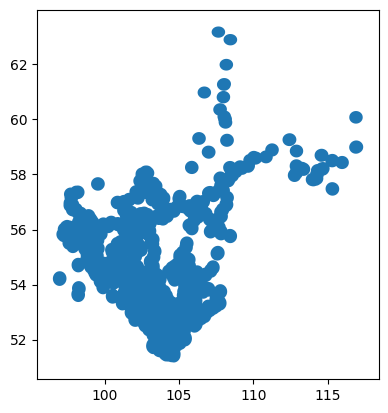

In [12]:
gdf.plot()

#### Rivers buffers

In [37]:
fileName = 'rivers_buffers.geojson'

path_to_json = my_data_path + "/MY buffers/" + fileName
# ignore_geometry=True
df_rivers_buf = gpd.read_file(path_to_json)
df_rivers_buf.rename(columns={'line': 'geom'}, inplace=True)
df_rivers_buf.head()

,name,basin,basin2,linewidth,sq,id,geom,layer,geometry
0,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...,10km,"MULTIPOLYGON (((90.55282 46.89255, 90.55393 46..."
1,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...,10km,"MULTIPOLYGON (((90.13800 47.48245, 90.13807 47..."
2,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...,10km,"MULTIPOLYGON (((90.14409 48.02387, 90.14790 48..."
3,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...,10km,"MULTIPOLYGON (((89.93364 48.19206, 89.93374 48..."
4,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...,10km,"MULTIPOLYGON (((88.70566 48.65663, 88.70543 48..."


In [40]:
rivers_buf_pd = pd.DataFrame(repalce_geometry_with_wkb(df_rivers_buf))
rivers_buf_pd.head()

,name,basin,basin2,linewidth,sq,id,geom,layer
0,Артюгина,Енисей,Артюгина,0.3,A01,1,0106000000010000000103000000010000001B01000060...,10km
1,Артюгина,Енисей,Артюгина,0.3,A01,1,010600000001000000010300000001000000FA00000049...,10km
2,Артюгина,Енисей,Артюгина,0.3,A01,1,0106000000010000000103000000010000007000000054...,10km
3,Артюгина,Енисей,Артюгина,0.3,A01,1,010600000001000000010300000001000000FE00000048...,10km
4,Артюгина,Енисей,Артюгина,0.3,A01,1,010600000001000000010300000001000000690F000041...,10km


In [43]:
file_name = 'rivers_buffers.json'
path = my_data_path + "MY buffers/" + file_name
rivers_buf_pd.to_json(path, index=False)

#### Roads

In [31]:
fileName = 'roads_buffers.geojson'
path_to_json = my_data_path + "/MY buffers/" + fileName
df_roads_buf = gpd.read_file(path_to_json)
df_roads_buf.rename(columns={'geom:1': 'geom'}, inplace=True)
df_roads_buf.head()

,type,id,geom,layer,geometry
0,федеральная,122,0105000020E61000000100000001020000006E00000025...,10km,"MULTIPOLYGON (((90.67215 54.65550, 90.67167 54..."
1,федеральная,122,0105000020E61000000100000001020000006E00000025...,10km,"MULTIPOLYGON (((114.22056 57.35911, 114.44369 ..."
2,федеральная,122,0105000020E61000000100000001020000006E00000025...,10km,"MULTIPOLYGON (((112.32971 63.02537, 112.33273 ..."
3,федеральная,122,0105000020E61000000100000001020000006E00000025...,20km,"MULTIPOLYGON (((90.20964 56.18562, 90.20948 56..."
4,федеральная,122,0105000020E61000000100000001020000006E00000025...,20km,"MULTIPOLYGON (((114.02561 57.55610, 114.02375 ..."


In [32]:
roads_buf_pd = pd.DataFrame(repalce_geometry_with_wkb(df_roads_buf))
roads_buf_pd.head()

,type,id,geom,layer
0,федеральная,122,010600000001000000010300000010000000BC6600008D...,10km
1,федеральная,122,0106000000010000000103000000010000008F010000F1...,10km
2,федеральная,122,0106000000010000000103000000010000001408000058...,10km
3,федеральная,122,010600000001000000010300000015000000F3A4000064...,20km
4,федеральная,122,010600000001000000010300000001000000CD02000069...,20km


In [34]:
fileName = 'roads_buffers.json'
path = my_data_path + "/MY buffers/" + fileName
roads_buf_pd.to_json(path, index=False)